<a href="https://colab.research.google.com/github/yvrjsharma/HugginFace_Gradio/blob/main/Flux_with_Gradio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

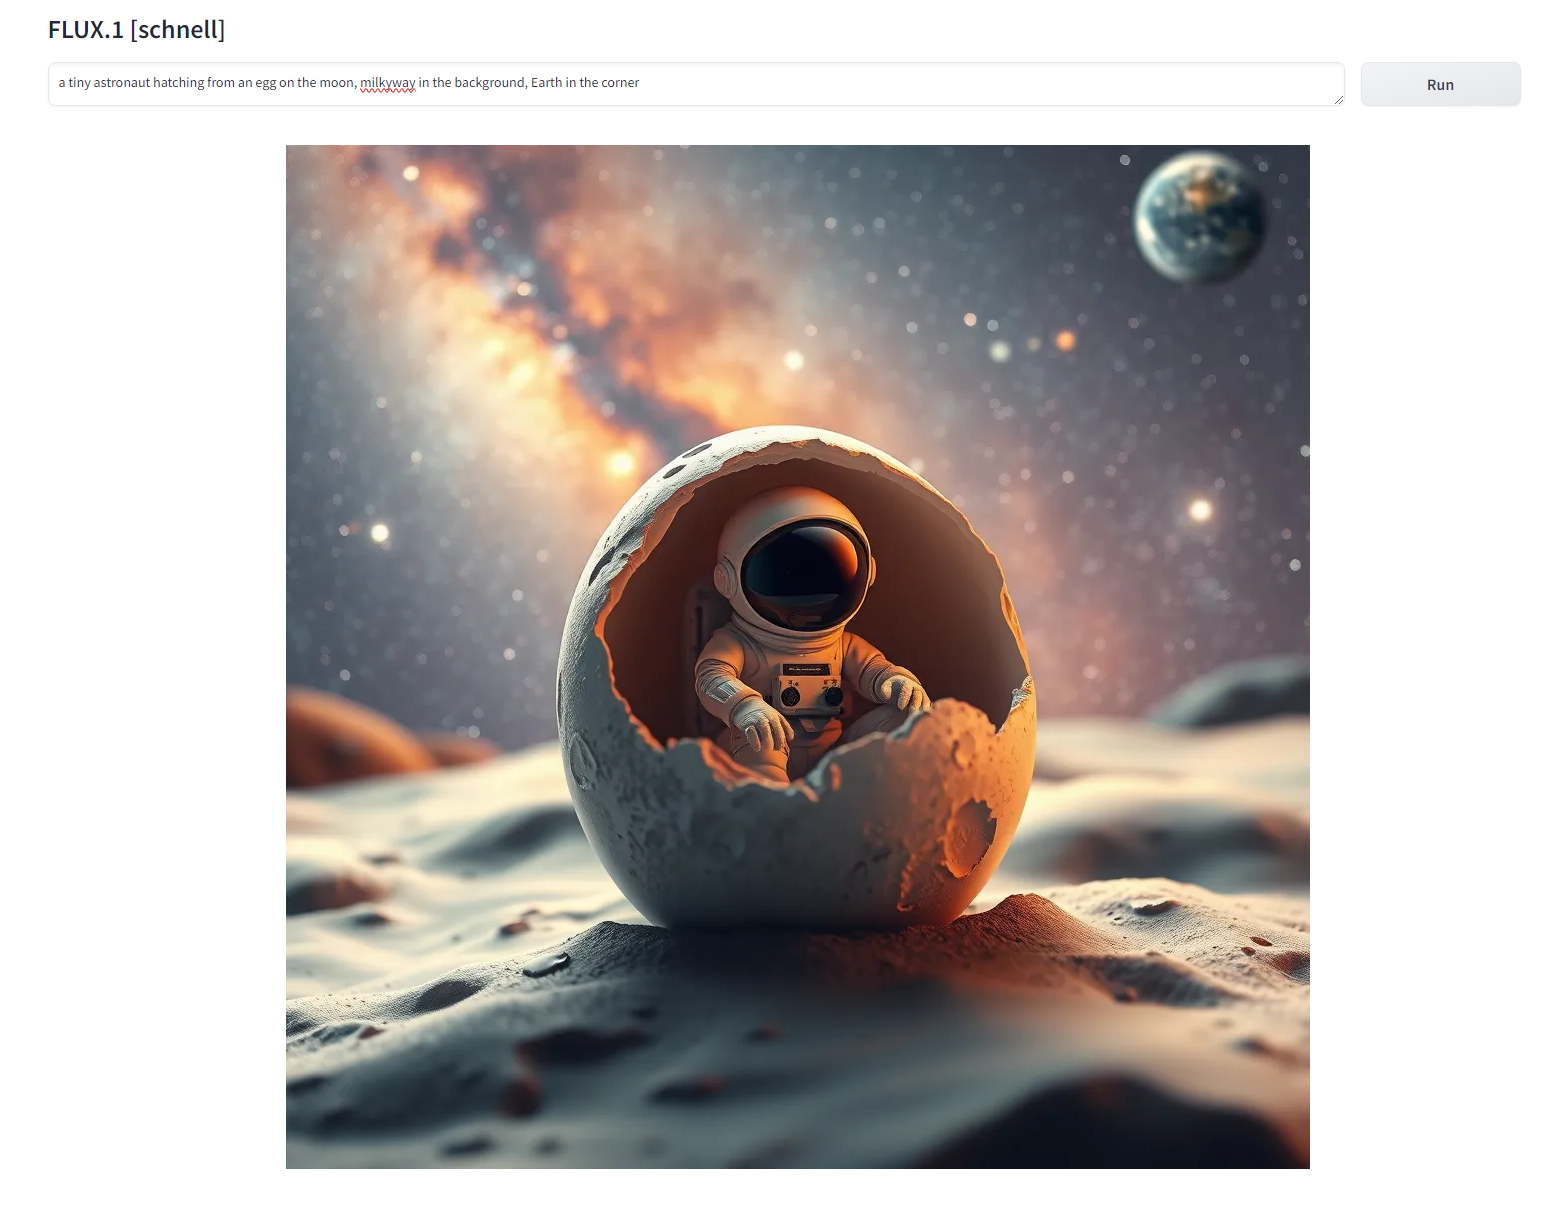

# **FLUX with Gradio**

In [ ]:
!pip install git+https://github.com/huggingface/diffusers.git

In [ ]:
!pip install accelerate invisible_watermark transformers==4.42.4 gradio -q

In [ ]:
import gradio as gr
import numpy as np
import random
import torch
from diffusers import DiffusionPipeline

dtype = torch.bfloat16
device = "cuda" if torch.cuda.is_available() else "cpu"

pipe = DiffusionPipeline.from_pretrained("black-forest-labs/FLUX.1-schnell", torch_dtype=dtype).to(device)

MAX_SEED = np.iinfo(np.int32).max

def infer(prompt, seed=42, randomize_seed=False, width=1024, height=1024, num_inference_steps=4, progress=gr.Progress(track_tqdm=True)):
    if randomize_seed:
        seed = random.randint(0, MAX_SEED)
    generator = torch.Generator().manual_seed(seed)
    image = pipe(
            prompt = prompt,
            width = width,
            height = height,
            num_inference_steps = num_inference_steps,
            generator = generator,
            guidance_scale=0.0
    ).images[0]
    return image, seed

examples = ["a tiny astronaut hatching from an egg on the moon",]

with gr.Blocks() as demo:

    with gr.Column():
        gr.Markdown(f"""# FLUX.1 [schnell]""")
        with gr.Row():
            prompt = gr.Text( label="Prompt", placeholder="Enter your prompt",container=False,)
            run_button = gr.Button("Run", scale=0)
        result = gr.Image(label="Result", show_label=False)

        with gr.Accordion("Advanced Settings", open=False):
            seed = gr.Slider( label="Seed",minimum=0,maximum=MAX_SEED,step=1,value=0,)
            randomize_seed = gr.Checkbox(label="Randomize seed", value=True)
            with gr.Row():
                width = gr.Slider( label="Width",minimum=256,maximum=2048,step=32,value=1024,)
                height = gr.Slider(label="Height",minimum=256,maximum=2048,step=32,value=1024,)
                num_inference_steps = gr.Slider(label="Number of inference steps",minimum=1,maximum=50,step=1,value=4,)
        gr.Examples(examples = examples, inputs = [prompt],)

    gr.on(triggers=[run_button.click, prompt.submit],
          fn = infer,
          inputs = [prompt, seed, randomize_seed, width, height, num_inference_steps],
          outputs = [result, seed])

demo.launch(share=True)